# Leer datasets

In [30]:
import pandas as pd
import numpy as np

blob = pd.read_csv('../data/blob5.csv')
blob.head()

,X1,X2,label
0,4.627632,1.075915,1
1,1.932565,5.601569,4
2,0.741996,5.033909,4
3,1.398611,0.948782,1
4,-8.750419,-7.231623,2


In [31]:
blob.drop(columns=['label'], inplace=True)

# Realizamos los clusters

In [32]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(blob)
kmeans_labels = kmeans.labels_
dbscan = DBSCAN(eps=0.7, min_samples=5)
dbscan.fit(blob)
dbscan_labels = dbscan.labels_
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm.fit(blob)
gmm_labels = gmm.predict(blob)

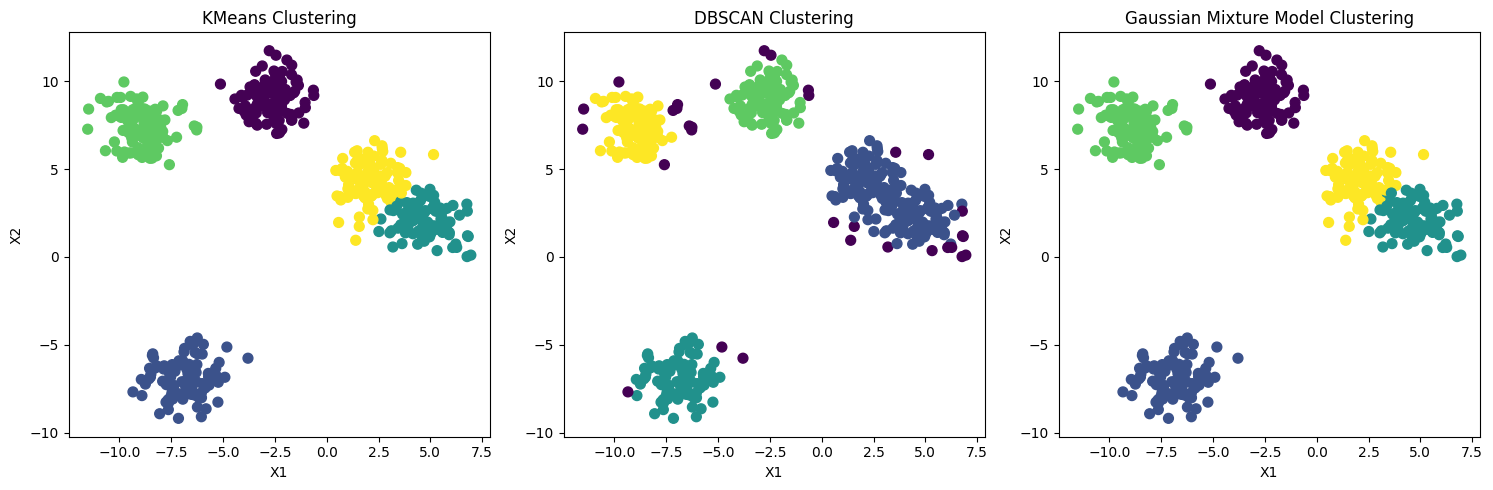

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(blob.iloc[:, 0], blob.iloc[:, 1], c=kmeans_labels, cmap='viridis', s=50)
plt.title('KMeans Clustering')
plt.xlabel(blob.columns[0])
plt.ylabel(blob.columns[1])
plt.subplot(1, 3, 2)
plt.scatter(blob.iloc[:, 0], blob.iloc[:, 1], c=dbscan_labels, cmap='viridis', s=50)
plt.title('DBSCAN Clustering')
plt.xlabel(blob.columns[0])
plt.ylabel(blob.columns[1])
plt.subplot(1, 3, 3)
plt.scatter(blob.iloc[:, 0], blob.iloc[:, 1], c=gmm_labels, cmap='viridis', s=50)
plt.title('Gaussian Mixture Model Clustering')
plt.xlabel(blob.columns[0])
plt.ylabel(blob.columns[1])
plt.tight_layout()
plt.show()

In [34]:
from sklearn.metrics import silhouette_score
kmeans_silhouette = silhouette_score(blob, kmeans_labels)
dbscan_silhouette = silhouette_score(blob, dbscan_labels)
gmm_silhouette = silhouette_score(blob, gmm_labels)
print(f'KMeans Silhouette Score: {kmeans_silhouette:.2f}')
print(f'DBSCAN Silhouette Score: {dbscan_silhouette:.2f}')
print(f'Gaussian Mixture Model Silhouette Score: {gmm_silhouette:.2f}')

KMeans Silhouette Score: 0.68
DBSCAN Silhouette Score: 0.65
Gaussian Mixture Model Silhouette Score: 0.68


# Interpretar

In [35]:
import sys
sys.path.append('..')
from ripper import MultiClassRipperClassifier
from dsgd import DSClassifierMultiQ
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree as sk_tree

## Kmeans

In [36]:
#dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(blob, kmeans_labels, test_size=0.2, random_state=42)


In [37]:
#muestrame los centros de los clusters
centers = kmeans.cluster_centers_
print("KMeans Cluster Centers:")
for i, center in enumerate(centers):
    print(f"Cluster {i}: {center}")

KMeans Cluster Centers:
Cluster 0: [-2.64387445  9.04103329]
Cluster 1: [-6.88093348 -6.9950069 ]
Cluster 2: [4.74346293 1.99434819]
Cluster 3: [-8.91925181  7.38961974]
Cluster 4: [2.13315564 4.35513167]


In [38]:
ripper = MultiClassRipperClassifier(random_state=43)
ripper.fit(X_train, y_train)
y_pred_ripper = ripper.predict(X_test)
print(f'Ripper Accuracy: {accuracy_score(y_test, y_pred_ripper):.2f}')

Ripper Accuracy: 0.97


In [39]:
ripper.print_rules()


Reglas para clase: 0
[[X1=-2.76--0.87] V [X1=-5.34--2.76^X2=>9.03] V [X1=-5.34--2.76^X2=8.07-9.03] V [X1=-5.34--2.76^X2=7.23-8.07]]

Reglas para clase: 1
[[X2=<-7.1] V [X2=-7.1--5.14] V [X1=-6.8--5.34^X2=-5.14-1.77]]

Reglas para clase: 2
[[X1=>4.74] V [X1=3.59-4.74] V [X1=2.03-3.59^X2=-5.14-1.77] V [X1=2.03-3.59^X2=1.77-2.83]]

Reglas para clase: 3
[[X1=<-8.88^X2=5.64-7.23] V [X1=-8.88--8.07^X2=5.64-7.23] V [X2=7.23-8.07^X1=-8.88--8.07] V [X1=<-8.88^X2=7.23-8.07] V [X1=<-8.88^X2=8.07-9.03] V [X1=-8.07--6.8^X2=8.07-9.03] V [X1=-8.88--8.07^X2=8.07-9.03] V [X1=-8.07--6.8^X2=5.64-7.23] V [X1=-8.88--8.07^X2=4.08-5.64] V [X1=<-8.88^X2=>9.03] V [X2=7.23-8.07^X1=-8.07--6.8] V [X1=-8.88--8.07^X2=>9.03] V [X2=5.64-7.23^X1=-6.8--5.34] V [X1=-8.07--6.8^X2=4.08-5.64]]

Reglas para clase: 4
[[X1=-0.87-2.03] V [X1=2.03-3.59^X2=4.08-5.64] V [X1=2.03-3.59^X2=2.83-4.08] V [X2=5.64-7.23^X1=2.03-3.59] V [X1=3.59-4.74^X2=4.08-5.64] V [X2=5.64-7.23^X1=>4.74]]


Decision Tree Accuracy: 1.00


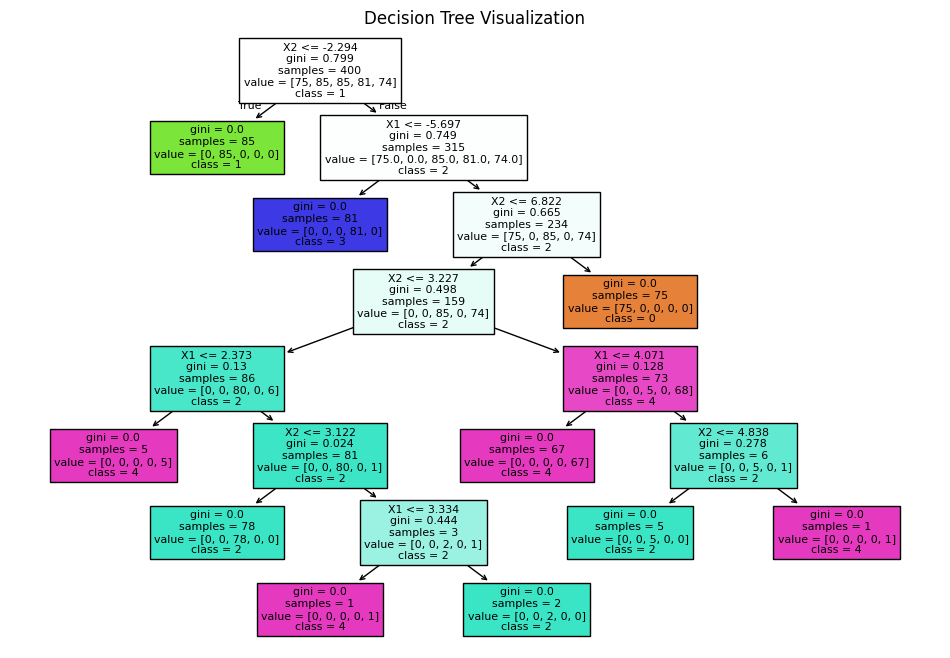

In [40]:
tree = DecisionTreeClassifier(random_state=44)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
print(f'Decision Tree Accuracy: {accuracy_score(y_test, y_pred_tree):.2f}')
# tree visualization
plt.figure(figsize=(12, 8))
sk_tree.plot_tree(tree, filled=True, feature_names=blob.columns, class_names=[str(i) for i in np.unique(y_train)])
plt.title('Decision Tree Visualization')
plt.show()

In [41]:
ds = DSClassifierMultiQ(n_clusters, min_iter=20, max_iter=200, debug_mode=True, lossfn="MSE", num_workers=0, min_dloss=1e-7)
X_train = X_train.to_numpy()
losses, epoch, dt = ds.fit(X_train, y_train, add_single_rules=True, single_rules_breaks=3, add_mult_rules=False, column_names=blob.columns.tolist())


Optimization started

Training time: 14.55s, epochs: 200

Least training loss reached: 0.017


In [42]:
ds.print_most_important_rules(threshold=0.32)



Most important rules for class 0

	[0.691] R7: X2 > 6.794
			0: 0.478	1: 0.000	2: 0.000	3: 0.522	4: 0.000	Unc: 0.000

	[0.571] R2: -2.376 < X1 < 1.217
			0: 0.326	1: 0.000	2: 0.000	3: 0.000	4: 0.674	Unc: 0.000

	[0.502] R1: -5.968 < X1 < -2.376
			0: 0.252	1: 0.748	2: 0.000	3: 0.000	4: 0.000	Unc: 0.000

Most important rules for class 1

	[0.865] R1: -5.968 < X1 < -2.376
			0: 0.252	1: 0.748	2: 0.000	3: 0.000	4: 0.000	Unc: 0.000

	[0.853] R0: X1 < -5.968
			0: 0.000	1: 0.736	2: 0.000	3: 0.253	4: 0.000	Unc: 0.011

	[0.717] R4: X2 < -0.973
			0: 0.000	1: 0.717	2: 0.000	3: 0.000	4: 0.000	Unc: 0.283

Most important rules for class 2

	[0.817] R3: X1 > 1.217
			0: 0.000	1: 0.000	2: 0.714	3: 0.000	4: 0.222	Unc: 0.064

	[0.737] R5: -0.973 < X2 < 2.911
			0: 0.000	1: 0.000	2: 0.737	3: 0.000	4: 0.000	Unc: 0.263

Most important rules for class 3

	[0.723] R7: X2 > 6.794
			0: 0.478	1: 0.000	2: 0.000	3: 0.522	4: 0.000	Unc: 0.000

	[0.535] R6: 2.911 < X2 < 6.794
			0: 0.000	1: 0.000	2: 0.041	3: 0

In [43]:
x_test = X_test.to_numpy()
y_pred_ds = ds.predict(x_test)
print(f'DSClassifier Accuracy: {accuracy_score(y_test, y_pred_ds):.2f}')

DSClassifier Accuracy: 0.98


## DBSCAN

In [44]:
#dividir los datos en entrenamiento y prueba
n_clusters_dbscan = len(np.unique(dbscan_labels))
max_label = np.max(dbscan_labels)
dbscan_labels = np.where(dbscan_labels == -1, max_label + 1, dbscan_labels)  # Assign a new label for noise points
X_train, X_test, y_train, y_test = train_test_split(blob, dbscan_labels, test_size=0.2, random_state=42)


In [45]:
ripper = MultiClassRipperClassifier(random_state=43)
ripper.fit(X_train, y_train)
y_pred_ripper = ripper.predict(X_test)
print(f'Ripper Accuracy: {accuracy_score(y_test, y_pred_ripper):.2f}')

Ripper Accuracy: 0.95


In [46]:
ripper.print_rules()


Reglas para clase: 0
[[X1=2.03-3.59] V [X1=3.59-4.74] V [X1=-0.87-2.03^X2=4.08-5.64] V [X1=>4.74^X2=2.83-4.08] V [X1=>4.74^X2=1.77-2.83] V [X1=-0.87-2.03] V [X1=>4.74]]

Reglas para clase: 1
[[X2=<-7.1] V [X2=-7.1--5.14] V [X1=-6.8--5.34^X2=-5.14-1.77]]

Reglas para clase: 2
[[X1=-2.76--0.87] V [X1=-5.34--2.76]]

Reglas para clase: 3
[[X1=<-8.88^X2=5.64-7.23] V [X1=-8.88--8.07^X2=5.64-7.23] V [X1=<-8.88] V [X1=-8.88--8.07^X2=7.23-8.07] V [X1=-8.88--8.07^X2=4.08-5.64] V [X1=-8.88--8.07^X2=8.07-9.03] V [X1=-8.07--6.8^X2=7.23-8.07] V [X1=-8.88--8.07^X2=>9.03] V [X2=5.64-7.23^X1=-8.07--6.8]]

Reglas para clase: 4
[[X1=>4.74^X2=5.64-7.23] V [X2=-5.14-1.77^X1=>4.74] V [X1=-8.07--6.8^X2=8.07-9.03] V [X1=-8.07--6.8^X2=4.08-5.64]]


Decision Tree Accuracy: 0.95


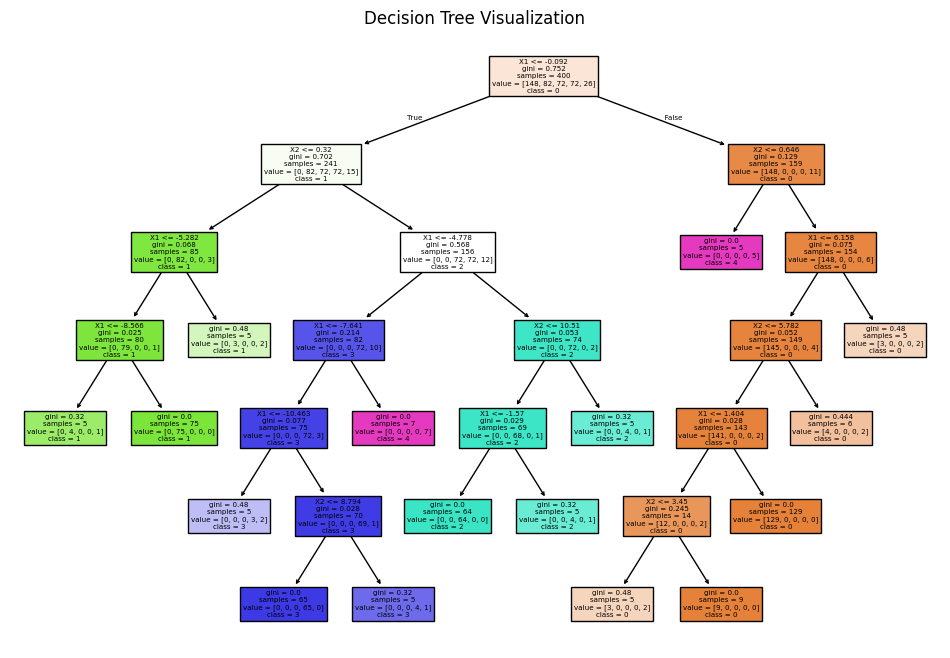

In [47]:
tree = DecisionTreeClassifier(random_state=44, min_samples_leaf=5)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
print(f'Decision Tree Accuracy: {accuracy_score(y_test, y_pred_tree):.2f}')
# tree visualization
plt.figure(figsize=(12, 8))
sk_tree.plot_tree(tree, filled=True, feature_names=blob.columns, class_names=[str(i) for i in np.unique(y_train)])
plt.title('Decision Tree Visualization')
plt.show()

In [48]:
ds = DSClassifierMultiQ(n_clusters_dbscan, min_iter=20, max_iter=200, debug_mode=True, lossfn="MSE", num_workers=0, min_dloss=1e-7)
X_train = X_train.to_numpy()
losses, epoch, dt = ds.fit(X_train, y_train, add_single_rules=True, single_rules_breaks=3, add_mult_rules=False, column_names=blob.columns.tolist())


Optimization started

Training time: 14.74s, epochs: 197

Least training loss reached: 0.027


In [49]:
ds.print_most_important_rules(threshold=0.001)



Most important rules for class 0

	[0.833] R6: 2.911 < X2 < 6.794
			0: 0.710	1: 0.000	2: 0.000	3: 0.267	4: 0.000	Unc: 0.023

	[0.753] R5: -0.973 < X2 < 2.911
			0: 0.753	1: 0.000	2: 0.000	3: 0.000	4: 0.000	Unc: 0.247

	[0.749] R3: X1 > 1.217
			0: 0.749	1: 0.000	2: 0.000	3: 0.000	4: 0.000	Unc: 0.251

	[0.609] R2: -2.376 < X1 < 1.217
			0: 0.385	1: 0.029	2: 0.406	3: 0.000	4: 0.144	Unc: 0.037

Most important rules for class 1

	[0.822] R0: X1 < -5.968
			0: 0.000	1: 0.675	2: 0.005	3: 0.269	4: 0.052	Unc: 0.000

	[0.768] R1: -5.968 < X1 < -2.376
			0: 0.000	1: 0.591	2: 0.293	3: 0.000	4: 0.114	Unc: 0.002

	[0.723] R4: X2 < -0.973
			0: 0.000	1: 0.722	2: 0.000	3: 0.000	4: 0.002	Unc: 0.276

	[0.167] R2: -2.376 < X1 < 1.217
			0: 0.385	1: 0.029	2: 0.406	3: 0.000	4: 0.144	Unc: 0.037

Most important rules for class 2

	[0.744] R7: X2 > 6.794
			0: 0.000	1: 0.000	2: 0.560	3: 0.345	4: 0.083	Unc: 0.012

	[0.625] R2: -2.376 < X1 < 1.217
			0: 0.385	1: 0.029	2: 0.406	3: 0.000	4: 0.144	Unc: 0.037



In [50]:
x_test = X_test.to_numpy()
y_pred_ds = ds.predict(x_test)
print(f'DSClassifier Accuracy: {accuracy_score(y_test, y_pred_ds):.2f}')

DSClassifier Accuracy: 0.94


## GMM

In [51]:
#dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(blob, gmm_labels, test_size=0.2, random_state=42)


In [52]:
ripper = MultiClassRipperClassifier(random_state=43)
ripper.fit(X_train, y_train)
y_pred_ripper = ripper.predict(X_test)
print(f'Ripper Accuracy: {accuracy_score(y_test, y_pred_ripper):.2f}')

Ripper Accuracy: 0.97


In [53]:
ripper.print_rules()


Reglas para clase: 0
[[X1=-2.76--0.87] V [X1=-5.34--2.76^X2=>9.03] V [X1=-5.34--2.76^X2=8.07-9.03] V [X1=-5.34--2.76^X2=7.23-8.07]]

Reglas para clase: 1
[[X2=<-7.1] V [X2=-7.1--5.14] V [X1=-6.8--5.34^X2=-5.14-1.77]]

Reglas para clase: 2
[[X2=1.77-2.83^X1=3.59-4.74] V [X1=>4.74] V [X1=3.59-4.74] V [X1=2.03-3.59^X2=-5.14-1.77] V [X2=1.77-2.83^X1=2.03-3.59]]

Reglas para clase: 3
[[X1=<-8.88^X2=5.64-7.23] V [X1=-8.88--8.07^X2=5.64-7.23] V [X2=7.23-8.07^X1=-8.88--8.07] V [X1=<-8.88^X2=7.23-8.07] V [X1=<-8.88^X2=8.07-9.03] V [X1=-8.07--6.8^X2=8.07-9.03] V [X1=-8.88--8.07^X2=8.07-9.03] V [X1=-8.07--6.8^X2=5.64-7.23] V [X1=-8.88--8.07^X2=4.08-5.64] V [X1=<-8.88^X2=>9.03] V [X2=7.23-8.07^X1=-8.07--6.8] V [X1=-8.88--8.07^X2=>9.03] V [X2=5.64-7.23^X1=-6.8--5.34] V [X1=-8.07--6.8^X2=4.08-5.64]]

Reglas para clase: 4
[[X1=-0.87-2.03] V [X1=2.03-3.59^X2=4.08-5.64] V [X1=2.03-3.59^X2=2.83-4.08] V [X1=2.03-3.59^X2=5.64-7.23] V [X1=3.59-4.74^X2=4.08-5.64] V [X2=5.64-7.23^X1=>4.74]]


Decision Tree Accuracy: 0.99


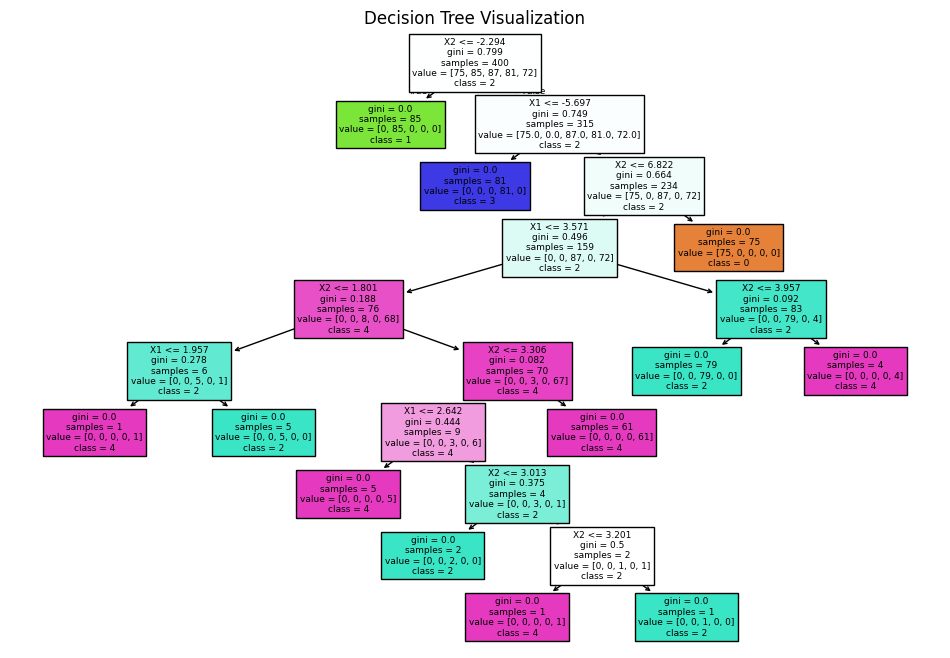

In [54]:
tree = DecisionTreeClassifier(random_state=44)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
print(f'Decision Tree Accuracy: {accuracy_score(y_test, y_pred_tree):.2f}')
# tree visualization
plt.figure(figsize=(12, 8))
sk_tree.plot_tree(tree, filled=True, feature_names=blob.columns, class_names=[str(i) for i in np.unique(y_train)])
plt.title('Decision Tree Visualization')
plt.show()

In [55]:
ds = DSClassifierMultiQ(n_clusters, min_iter=20, max_iter=200, debug_mode=True, lossfn="MSE", num_workers=0, min_dloss=1e-7)
X_train = X_train.to_numpy()
losses, epoch, dt = ds.fit(X_train, y_train, add_single_rules=True, single_rules_breaks=3, add_mult_rules=False, column_names=blob.columns.tolist())


Optimization started

Training time: 10.76s, epochs: 145

Least training loss reached: 0.021


In [56]:
ds.print_most_important_rules(threshold=0.32)



Most important rules for class 0

	[0.712] R7: X2 > 6.794
			0: 0.506	1: 0.000	2: 0.000	3: 0.494	4: 0.000	Unc: 0.000

	[0.627] R2: -2.376 < X1 < 1.217
			0: 0.394	1: 0.000	2: 0.000	3: 0.000	4: 0.606	Unc: 0.000

	[0.559] R1: -5.968 < X1 < -2.376
			0: 0.312	1: 0.688	2: 0.000	3: 0.000	4: 0.000	Unc: 0.000

Most important rules for class 1

	[0.829] R1: -5.968 < X1 < -2.376
			0: 0.312	1: 0.688	2: 0.000	3: 0.000	4: 0.000	Unc: 0.000

	[0.817] R0: X1 < -5.968
			0: 0.000	1: 0.685	2: 0.000	3: 0.292	4: 0.000	Unc: 0.024

	[0.628] R4: X2 < -0.973
			0: 0.000	1: 0.628	2: 0.000	3: 0.000	4: 0.000	Unc: 0.372

Most important rules for class 2

	[0.787] R3: X1 > 1.217
			0: 0.000	1: 0.000	2: 0.683	3: 0.000	4: 0.224	Unc: 0.093

	[0.632] R5: -0.973 < X2 < 2.911
			0: 0.000	1: 0.000	2: 0.632	3: 0.000	4: 0.000	Unc: 0.368

Most important rules for class 3

	[0.703] R7: X2 > 6.794
			0: 0.506	1: 0.000	2: 0.000	3: 0.494	4: 0.000	Unc: 0.000

	[0.572] R6: 2.911 < X2 < 6.794
			0: 0.000	1: 0.000	2: 0.053	3: 0

In [57]:
x_test = X_test.to_numpy()
y_pred_ds = ds.predict(x_test)
print(f'DSClassifier Accuracy: {accuracy_score(y_test, y_pred_ds):.2f}')

DSClassifier Accuracy: 0.98
